Baseline BERT

Import necessary packages

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 86 kB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 11.7 MB/s 
     |████████████████████████████████| 596 kB 16.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 40.7 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 140 kB 49.3 MB/s 
     |████████████████████████████████| 212 kB 41.8 MB/s 
     |████████████████████████████████| 127 kB 47.4 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 144 kB 45.8 MB/s 
     |████████████████████████████████| 271 kB 26.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
ERROR: pip's dependency resolver does not currently take into account all t

Copy baseline model code

In [ ]:
from pandas.core.base import NoNewAttributesMixin
import re
import numpy as np
import pandas as pd
import datasets
from datasets import load_dataset, Dataset
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    BertTokenizer,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    TFAutoModelForMaskedLM,
    pipeline,
)


CONTENT_ROW = "content"
SCORE = "score"
TOKEN_STRING = "token_str"

DEFAULT_GENDER_IDENTIFIERS = [
    "she",
    "her",
    "hers",
    "woman",
    "women",
    "female",
    "he",
    "his",
    "him",
    "man",
    "men",
    "male",
]

WOMAN_KEYWORDS = ["woman", "women", "female", "she", "her", "hers"]
MAN_KEYWORDS = ["man", "men", "male", "he", "his", "him"]

TOP_K = 100


class Bert:
    def __init__(self, model_checkpoint="bert-base-uncased"):
        """
        Instantiates model and tokenizer based on pretrained bert-base-uncased model.
        Returns:
        tokenizer -- AutoTokenizer for the model
        model -- pretrained BertForMaskedLM
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        self.model = BertForMaskedLM.from_pretrained(model_checkpoint, output_hidden_states=True)
        #self.model = BertForMaskedLM.from_pretrained("jbreuch/bert-news-v3", use_auth_token=True, from_tf=True, output_hidden_states=True)

    def mask_single_gender(self, gender_identifiers=[], input_text=""):
        """
        Masks the input text with the mask_token for the given tokenizer.
        Chooses single, center-most relevant token to mask.
        Arguments:
          tokenizer -- tokenizer to identify the token_str
          gender_identifiers (optional) -- list of identifiers to mask (i.e. ["Megan", "boy", "guy"])
          input_text -- the string to mask
        Returns:
          output_text -- masked version of the input_text
        Example: ("[Mask] should be president!") : {'she' : 0.50, 'he': 0.5}
        """
        if not gender_identifiers:
            gender_identifiers = DEFAULT_GENDER_IDENTIFIERS
        regex = re.compile(r"\b(?:%s)\b" % "|".join(gender_identifiers))
        matches = list(re.finditer(regex, input_text.lower()))

        middle_index = len(input_text) / 2
        single_match_start = 0
        single_match_end = 0
        min_distance = 10000

        if len(matches) == 0:
            return input_text
        elif len(matches) == 1:
            single_match_start = matches[0].start()
            single_match_end = matches[0].end()
        else:
            match_indices = []
            for match in matches:
                match_indices.append((match.start(), match.end()))
            for match_index_tuple in match_indices:
                match_index = int((match_index_tuple[0] + match_index_tuple[1]) / 2)
                current_distance = abs(match_index - middle_index)
                if current_distance < min_distance:
                    min_distance = current_distance
                    single_match_start = match_index_tuple[0]
                    single_match_end = match_index_tuple[1]

        label = input_text[single_match_start:single_match_end].strip()
        input_text = (
            input_text[:single_match_start] + "[MASK]" + input_text[single_match_end:]
        )
        return input_text, label

    def mask_gender(self, gender_identifiers=[], input_text=""):
        """
        Masks the input text with the mask_token for the given tokenizer
        Arguments:
          tokenizer -- tokenizer to identify the token_str
          gender_identifiers (optional) -- list of identifiers to mask (i.e. ["Megan", "boy", "guy"])
          input_text -- the string to mask
        Returns:
          output_text -- masked version of the input_text
        Example: ("[Mask] should be president!") : {'she' : 0.50, 'he': 0.5}
        """
        if not gender_identifiers:
            gender_identifiers = DEFAULT_GENDER_IDENTIFIERS
        regex = re.compile(r"\b(?:%s)\b" % "|".join(gender_identifiers))
        return regex.sub(self.tokenizer.mask_token, input_text)

    def split_to_contexts(self, eval_dataset, context_size=128):
        concat_text = " ".join(eval_dataset)
        words = concat_text.split()
        grouped_words = [
            " ".join(words[i : i + context_size])
            for i in range(0, len(words), context_size)
        ]
        return grouped_words

    def read_eval_data(self, dataset, downsample=False):
        eval_dataset = dataset["validation"]
        # Downsample if running on colab
        if downsample:
            downsampled_dataset = dataset["validation"].train_test_split(
                test_size=500, seed=42
            )
            print(downsampled_dataset)
            eval_dataset = downsampled_dataset["test"]
        repartitioned = self.split_to_contexts(eval_dataset[CONTENT_ROW])
        eval_dataset_df = pd.DataFrame({"content": repartitioned})
        return eval_dataset_df

    def compute_single_prob(self, predictions):
        woman_prob_numerator = 0
        man_prob_numerator = 0
        all_gender_denominator = 0
        for prediction in predictions:
            if prediction[TOKEN_STRING] in WOMAN_KEYWORDS:
                woman_prob_numerator += prediction[SCORE]
                all_gender_denominator += prediction[SCORE]
            if prediction[TOKEN_STRING] in MAN_KEYWORDS:
                man_prob_numerator += prediction[SCORE]
                all_gender_denominator += prediction[SCORE]
        if all_gender_denominator == 0:
            woman_prob = 0
            man_prob = 0
        else:
            woman_prob = woman_prob_numerator / all_gender_denominator
            man_prob = man_prob_numerator / all_gender_denominator
            assert woman_prob + man_prob == 1.0
        return woman_prob, man_prob

    def compute_probs(self, predictions):
        """
        Computes normalized gender probability given a list of predictions
        (corresponding to a single context)
        Arguments:
          predictions -- list of predictions output for a single context
        Returns:
          output_text -- woman_prob, man_prob
        """
        woman_prob = 0
        man_prob = 0
        if len(predictions) != TOP_K:
            woman_prob_list = []
            man_prob_list = []
            for prediction in predictions:
                woman_prob, man_prob = self.compute_single_prob(prediction)
                woman_prob_list.append(woman_prob)
                man_prob_list.append(man_prob)
            woman_prob = np.mean(woman_prob_list)
            man_prob = np.mean(man_prob_list)
        else:
            woman_prob, man_prob = self.compute_single_prob(predictions)
        return woman_prob, man_prob

    def evaluate(self, eval_df):
        model_fn = pipeline("fill-mask", model=self.model, tokenizer=self.tokenizer)
        predictions = []
        woman_probs = []
        man_probs = []
        for prediction in tqdm(model_fn(KeyDataset(eval_df, "content"), top_k=TOP_K)):
            (woman_prob, man_prob) = bert.compute_probs(prediction)
            woman_probs.append(woman_prob)
            man_probs.append(man_prob)

        probability_output = pd.DataFrame(
            {
                "content": eval_df["content"],
                "label": eval_df["label"],
                "female_probs": woman_probs,
                "male_probs": man_probs,
            }
        )

        return probability_output


    def get_context_indices(self, context, gender_keywords, target_keywords):
        # masked_context = self.mask_single_gender(gender_keywords, context)
        masked_context = context.split()
        #if "[MASK]" not in masked_context[0]:
        if "[MASK]" not in masked_context:
          return None

        gender_indices = []
        target_indices = []

        #masked_context = masked_context[0].split()
        for i in range(0, len(masked_context)):
          if masked_context[i].lower().strip() in target_keywords:
            target_indices.append(i)
          if masked_context[i] == "[MASK]":
            gender_indices.append(i)
        return gender_indices, target_indices

    def get_cosine_similarities(self, context, label, gender_keywords, target_keywords):
        """
        Computes cosine similarities between gender_keyword and target_keywords
        Arguments:
          context -- input context (non-masked)
          gender_keywords -- list of gender keywords e.g. woman keywords
          target_keywords -- list of target keywords e.g. strength keywords
        Returns:
          mean cosine similarity or None if no keyword match 
        """
        tok = self.tokenizer(context, return_tensors='pt')
        sent_idxs = self.get_context_indices(context, gender_keywords, target_keywords)
        if sent_idxs is None:
            return None 
        gender_index = sent_idxs[0][0]
        target_indices = sent_idxs[1]

        cosine_sims = dict()
        context_list = context.split()
        for target_index in target_indices: 
            tok_ids = [np.where(np.array(tok.word_ids()) == idx) for idx in [gender_index, target_index]]
            target_word = context_list[target_index]
            gender_word = label

            with torch.no_grad():
                out = self.model(**tok)

            # Only grab the last hidden state
            states = out.hidden_states[-1].squeeze()
            embs = states[[tup[0][0] for tup in tok_ids]]

            pronoun_embedding = embs[0].reshape(1, -1)
            target_embedding = embs[1].reshape(1, -1)
          
            cosine_sim = torch.cosine_similarity(pronoun_embedding, target_embedding)
            if (gender_word, target_word) not in cosine_sims:
                cosine_sims[(gender_word.lower(), target_word.lower())] = []
                cosine_sims[(gender_word.lower(), target_word.lower())].append(cosine_sim.item())
            else: 
                cosine_sims[(gender_word.lower(), target_word.lower())].append(cosine_sim.item())
        if len(cosine_sims) == 0:
            return None
        return cosine_sims

Compute similarity for word embeddings

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
bert = Bert()
data_files = {"train": "train.csv", "test": "dev.csv", "validation": "test.csv"}
dataset = load_dataset("myradeng/cs-230-news-v3", data_files=data_files)

dataset = bert.read_eval_data(dataset, False)
for idx, row in dataset.iterrows():
  output = bert.mask_single_gender(input_text=row["content"])
  dataset.loc[idx, "content"] = output[0]
  dataset.loc[idx, "label"] = output[1]
dataset = dataset[dataset["content"].str.contains("\[MASK\]")]
dataset = Dataset.from_pandas(dataset)
probability_output = bert.evaluate(dataset)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using custom data configuration myradeng--cs-230-news-v3-60a1a3b484da7bd8


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/myradeng___csv/myradeng--cs-230-news-v3-60a1a3b484da7bd8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3809 [00:00<?, ?it/s]

In [ ]:
# Get ALL (aggregate level) CONDITIONAL probabilities 
# Make sure this code stays the same
# In our milestone report, percentages for both all_male and all_female were in the ~70s range
all_male = np.mean(probability_output[~probability_output["label"].apply(lambda x: any([k in x for k in WOMAN_KEYWORDS]))]['male_probs'])
all_female = np.mean(probability_output[probability_output["label"].apply(lambda x: any([k in x for k in WOMAN_KEYWORDS]))]['female_probs'])
print(all_male, all_female)

0.8411518981780208 0.6152826574075669


Get target word contexts

In [5]:
STRENGTH = ["power", "strong", "confident", "dominant", "potent", "command", "assert", "loud", "bold", "succeed",
"triumph", "leader", "shout", "dynamic", "winner"]
WEAK = ["weak", "surrender", "timid", "vulnerable", "weakness", "wispy", "withdraw", "yield", "failure", "shy",
"follow", "lose", "fragile", "afraid", "loser"]

INTELLIGENCE = ["precocious", "resourceful", "inquisitive", "genius", "inventive", "astute", "adaptable", "reflective",
"discerning", "intuitive", "inquiring", "judicious", "analytical", "apt", "venerable", "imaginative",
"shrewd", "thoughtful", "wise", "smart", "ingenious", "clever", "brilliant", "logical", "intelligent"]
APPEARANCE = ["alluring", "voluptuous", "blushing", "homely", "plump", "sensual", "gorgeous", "slim", "bald",
"athletic", "fashionable", "stout", "ugly", "muscular", "slender"]

CAREER = ["executive", "management", "professional", "corporation", "salary", "office", "business", "career"]
FAMILY = ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives"]

In [10]:
strong_contexts = probability_output[probability_output["content"].apply(lambda x: any([k in x for k in STRENGTH]))]
weak_contexts = probability_output[probability_output["content"].apply(lambda x: any([k in x for k in WEAK]))]

intelligence_contexts = probability_output[probability_output["content"].apply(lambda x: any([k in x for k in INTELLIGENCE]))]
appearance_contexts = probability_output[probability_output["content"].apply(lambda x: any([k in x for k in APPEARANCE]))]

career_contexts = probability_output[probability_output["content"].apply(lambda x: any([k in x for k in CAREER]))]
family_contexts = probability_output[probability_output["content"].apply(lambda x: any([k in x for k in FAMILY]))]

Compute word embeddings 

In [ ]:
import torch

In [ ]:
def get_cosine_sim_dict(bert, content_df, gender_keywords, target_keywords):
  cosine_sims = dict()
  for idx, row in content_df.iterrows():
    # TODO update these key words 
    cosine_sim = bert.get_cosine_similarities(row["content"], row["label"], gender_keywords, target_keywords)
    #print(row["content"])
    #print(cosine_sim)
    if cosine_sim is not None:
      for k, v in cosine_sim.items(): 
        if k in cosine_sims.keys():
          cosine_sims[k] += v
        else:
          cosine_sims[k] = v
  return cosine_sims 

In [ ]:
bert = Bert()

All TF 2.0 model weights were used when initializing BertForMaskedLM.

Some weights of BertForMaskedLM were not initialized from the TF 2.0 model and are newly initialized: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
all_cosine_sims = dict()

In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, MAN_KEYWORDS, STRENGTH)

for k1 in MAN_KEYWORDS:
  for k2 in STRENGTH:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.19038404524326324]
[0.19821538031101227]
[0.23245105147361755, 0.5106070041656494]
[0.5779248476028442]
[0.11775536090135574, 0.18196755647659302]
[0.35321375727653503, 0.19316306710243225]
[0.23458722233772278, 0.2955898940563202, 0.2623235583305359, 0.22427554428577423, 0.3095925748348236, 0.19274701178073883, 0.21616443991661072, 0.35225966572761536, 0.33786740899086, 0.2293417751789093, 0.5135105848312378, 0.14858399331569672, 0.22530223429203033, 0.22666607797145844, 0.1374872624874115, 0.3169196844100952, 0.3179256021976471, 0.20063328742980957, 0.1954968273639679, 0.13173739612102509, 0.34591513872146606, 0.2044803500175476, 0.35268548130989075, 0.2926947772502899, 0.2912698984146118, 0.4858035147190094, 0.2816014587879181, 0.2292121797800064, 0.18386250734329224, 0.4224558174610138, 0.3376094698905945, 0.1249527633190155, 0.2756907641887665, 0.3400491774082184, 0.38429129123687744]
[0.3324812352657318, 0.33281296491622925, 0.4774852693080902, 0.30052483081817627, 0.237590417

In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, WOMAN_KEYWORDS, STRENGTH)

for k1 in WOMAN_KEYWORDS:
  for k2 in STRENGTH:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.15391908586025238, 0.3403714597225189, 0.3250308930873871]
[0.09086336195468903]
[0.21477095782756805, 0.2607555091381073]
[0.42273494601249695]
[0.3237921893596649]
[0.22693488001823425]
[0.24103321135044098]
[0.27832671999931335, 0.256084144115448, 0.21478798985481262, 0.2725793123245239, 0.1525139957666397, 0.2864910364151001, 0.3456249237060547, 0.21167097985744476, 0.314104825258255, 0.3425656259059906, 0.2518337368965149, 0.26953479647636414, 0.33649399876594543]
[0.3786148428916931, 0.2802605628967285, 0.15291860699653625, 0.29819852113723755, 0.4007611870765686, 0.36798232793807983, 0.29031839966773987, 0.11150211095809937, 0.3427252471446991, 0.06087767705321312, 0.17754054069519043, 0.5332058668136597]
[0.24418681859970093, 0.2798415720462799, 0.5081906914710999]
[0.2986854910850525, 0.28694984316825867, 0.07942143827676773]
[0.11998947709798813]
[0.17416490614414215]
[0.24885331094264984]
[0.27627402544021606, 0.2841193675994873, 0.3121446371078491, 0.24333149194717407, 0

In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, MAN_KEYWORDS, WEAK)

for k1 in MAN_KEYWORDS:
  for k2 in WEAK:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.34527021646499634]
[0.3070858120918274, 0.3716874122619629]
[0.4646264612674713, 0.4216352105140686, 0.2849554419517517]
[0.2824079096317291]
[0.30433011054992676, 0.2084418684244156]
[0.31524035334587097, 0.1828082650899887, 0.12114060670137405, 0.3267394006252289, 0.09633126109838486, 0.2523718774318695, 0.250494122505188, 0.22033703327178955, 0.24888741970062256]
[0.2873052954673767]
[0.12326405197381973, 0.21700868010520935, 0.11297332495450974]
[0.06867638975381851, 0.24621516466140747]
[0.35475245118141174, 0.21664534509181976]
[0.46688392758369446]
[0.2559780478477478]
[0.06538039445877075]
[0.3777269124984741, 0.30936041474342346, 0.06470811367034912, 0.298956036567688]
[0.244790181517601]
[0.2732500731945038]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, WOMAN_KEYWORDS, WEAK)

for k1 in WOMAN_KEYWORDS:
  for k2 in WEAK:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.2749859690666199]
[0.20844393968582153, 0.25343188643455505, 0.36592814326286316]
[0.27160272002220154]
[0.3222315013408661, 0.3633348345756531]
[0.275269091129303]
[0.27770647406578064]
[0.34005317091941833]
[0.2276969999074936]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, MAN_KEYWORDS, INTELLIGENCE)

for k1 in MAN_KEYWORDS:
  for k2 in INTELLIGENCE:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.2698095738887787]
[0.11361927539110184]
[0.25622159242630005]
[0.27321186661720276]
[0.3880351781845093]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, WOMAN_KEYWORDS, INTELLIGENCE)

for k1 in WOMAN_KEYWORDS:
  for k2 in INTELLIGENCE:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.27641424536705017]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, WOMAN_KEYWORDS, APPEARANCE)

for k1 in WOMAN_KEYWORDS:
  for k2 in APPEARANCE:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.3059508800506592]
[0.1396474838256836]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, MAN_KEYWORDS, APPEARANCE)

for k1 in MAN_KEYWORDS:
  for k2 in APPEARANCE:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.3802856206893921]
[0.38761526346206665]
[0.24000926315784454]
[0.27671608328819275]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, WOMAN_KEYWORDS, CAREER)

for k1 in WOMAN_KEYWORDS:
  for k2 in CAREER:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.32344499230384827, 0.23718461394309998]
[0.1280674785375595]
[0.23633959889411926, 0.35888129472732544, 0.274738073348999]
[0.3508383631706238]
[0.21208897233009338, 0.2766099274158478, 0.27185550332069397]
[0.1259610950946808]
[0.3137364983558655]
[0.23174472153186798, 0.14212730526924133, 0.4091642200946808, 0.21947833895683289]
[0.34980055689811707, 0.19381919503211975]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, MAN_KEYWORDS, CAREER)

for k1 in MAN_KEYWORDS:
  for k2 in CAREER:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.25934621691703796]
[0.2794618308544159, 0.2035285383462906, 0.49032294750213623, 0.33585092425346375, 0.23987561464309692, 0.33238956332206726, 0.2485564649105072, 0.295783668756485, 0.2710680663585663, 0.23383505642414093, 0.17805089056491852, 0.22593970596790314, 0.27995043992996216, 0.39737775921821594, 0.2878510653972626, 0.22698286175727844, 0.4884987771511078, 0.2928254306316376]
[0.24444261193275452, 0.42781496047973633, 0.22804979979991913]
[0.43430840969085693]
[0.3517094850540161]
[0.13240230083465576, 0.19127780199050903, 0.3154260516166687, 0.3683699071407318, 0.3187977373600006, 0.22996895015239716, 0.41083914041519165, 0.14732572436332703, 0.2651917040348053, 0.38876575231552124]
[0.02414057031273842, 0.10946845263242722, 0.3096563220024109, 0.3260510563850403, 0.10676491260528564, 0.21226687729358673, 0.09252516180276871, 0.27166256308555603, 0.3069983720779419, 0.1959248036146164, 0.3691991865634918, 0.22376446425914764, 0.3961297571659088, 0.16735641658306122, 0.063

In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, WOMAN_KEYWORDS, FAMILY)

for k1 in WOMAN_KEYWORDS:
  for k2 in FAMILY:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.25693076848983765]
[0.5469449758529663, 0.15179704129695892]
[0.24472570419311523]
[0.25937163829803467, 0.30123385787010193]
[0.3812215328216553, 0.38797807693481445, 0.3442178964614868, 0.38250118494033813]
[0.1775902807712555, 0.2859228849411011]
[0.21312998235225677, 0.3761867582798004, 0.4280935227870941]
[0.4051375985145569, 0.23582488298416138, 0.5013719201087952, 0.12995992600917816]
[0.21824900805950165, 0.08230685442686081, 0.23070959746837616, 0.4019583761692047]
[0.49816417694091797, 0.23852090537548065]
[0.536981999874115, 0.4473761022090912, 0.21805645525455475]


In [ ]:
cosine_sims = get_cosine_sim_dict(bert, strong_contexts, MAN_KEYWORDS, FAMILY)

for k1 in MAN_KEYWORDS:
  for k2 in FAMILY:
    if (k1, k2) in cosine_sims.keys():
      print(cosine_sims[(k1, k2)])
      all_cosine_sims[(k1, k2)] = cosine_sims[(k1, k2)]

[0.2604176700115204, 0.2764558494091034]
[0.3144899010658264]
[0.6055769920349121]
[0.37144988775253296]
[0.2229326367378235]
[0.2268037050962448, 0.19933868944644928, 0.42792028188705444, 0.3057323694229126, 0.276388019323349, 0.36349886655807495, 0.26708605885505676, 0.10299552977085114, 0.19294869899749756, 0.14017845690250397, 0.23073206841945648, 0.06281456351280212, 0.24122078716754913, 0.25454455614089966, 0.2800775170326233, 0.25520315766334534, 0.3023713529109955]
[0.26843708753585815, 0.25473877787590027, 0.23588927090168, 0.14250445365905762, 0.1501363068819046]
[0.20143821835517883, 0.2286567986011505, 0.3165722191333771, 0.24665679037570953, 0.24822013080120087, 0.2112785279750824, 0.1071966215968132, 0.4305402636528015, 0.14773035049438477, 0.3979799449443817, 0.28441908955574036, 0.22950416803359985, 0.35135889053344727]
[0.149545356631279, 0.2609913945198059, 0.6001856327056885, 0.33413562178611755, 0.25984111428260803, 0.3415944576263428, 0.3699052631855011, 0.04322052

In [ ]:
all_cosine_sims

In [ ]:
# Get two lists of average cosine similarities for all gender pronouns 
# to target word, ordered by word
def get_cosine_sim_lists(all_cosine_sims, target_words):
  woman_avg_cosine_sims = []
  man_avg_cosine_sims = []
  target_words_list = []

  for keyword in target_words:
    woman_sum = []
    for woman_keyword in WOMAN_KEYWORDS:
      val = all_cosine_sims.get((woman_keyword, keyword))
      if (val != None): woman_sum.extend(val)
    man_sum = []
    for man_keyword in MAN_KEYWORDS:
      val = all_cosine_sims.get((man_keyword, keyword))
      if (val != None): man_sum.extend(val)
    target_words_list.append(keyword)
    woman_avg_cosine_sims.append(np.mean(woman_sum))
    man_avg_cosine_sims.append(np.mean(man_sum))
  return target_words_list, woman_avg_cosine_sims, man_avg_cosine_sims
  

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


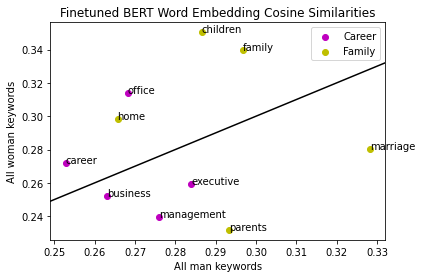

In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math
  
target_words_strength, woman_avg_cosine_sims_strength, man_avg_cosine_sims_strength = get_cosine_sim_lists(all_cosine_sims, STRENGTH)
target_words_weak, woman_avg_cosine_sims_weak, man_avg_cosine_sims_weak = get_cosine_sim_lists(all_cosine_sims, WEAK)
target_words_intelligence, woman_avg_cosine_sims_intelligence, man_avg_cosine_sims_intelligence = get_cosine_sim_lists(all_cosine_sims, INTELLIGENCE)
target_words_appearance, woman_avg_cosine_sims_appearance, man_avg_cosine_sims_appearance = get_cosine_sim_lists(all_cosine_sims, APPEARANCE)
target_words_career, woman_avg_cosine_sims_career, man_avg_cosine_sims_career = get_cosine_sim_lists(all_cosine_sims, CAREER)
target_words_family, woman_avg_cosine_sims_family, man_avg_cosine_sims_family = get_cosine_sim_lists(all_cosine_sims, FAMILY)

X = [0.05, 0.4]
Y = [0.05, 0.4]
# Using Numpy to create an array X
X_strength = np.array(man_avg_cosine_sims_strength)
y_strength = np.array(woman_avg_cosine_sims_strength)

X_weak = np.array(man_avg_cosine_sims_weak)
y_weak = np.array(woman_avg_cosine_sims_weak)

# X_intelligence = np.array(man_avg_cosine_sims_intelligence)
# y_intelligence = np.array(woman_avg_cosine_sims_intelligence)

# X_appearance = np.array(man_avg_cosine_sims_appearance)
# y_appearance = np.array(woman_avg_cosine_sims_appearance)

# X_career = np.array(man_avg_cosine_sims_career)
# y_career = np.array(woman_avg_cosine_sims_career)

# X_family = np.array(man_avg_cosine_sims_family)
# y_family = np.array(woman_avg_cosine_sims_family)  

# Plotting both the curves simultaneously
# plt.scatter(X_strength, y_strength, color='r', label='Strength')
# plt.scatter(X_weak, y_weak, color='b', label = 'Weakness')
# plt.scatter(X_intelligence, y_intelligence, color='g', label = 'Intelligence')
# plt.scatter(X_appearance, y_appearance, color='c', label='Appearance')
plt.scatter(X_career, y_career, color='m', label='Career')
plt.scatter(X_family, y_family, color='y', label='Family')

# for i in range(0, len(X_strength)):
#   plt.annotate(target_words_strength[i], (X_strength[i], y_strength[i]))
# for i in range(0, len(X_weak)): 
#   plt.annotate(target_words_weak[i], (X_weak[i], y_weak[i]))
# for i in range(0, len(X_intelligence)):
#   plt.annotate(target_words_intelligence[i], (X_intelligence[i], y_intelligence[i]))
# for i in range(0, len(X_appearance)):
#   plt.annotate(target_words_appearance[i], (X_appearance[i], y_appearance[i]))
for i in range(0, len(X_career)):
  plt.annotate(target_words_career[i], (X_career[i], y_career[i]))
for i in range(0, len(X_family)):
  plt.annotate(target_words_family[i], (X_family[i], y_family[i]))

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, color='k', scalex=False, scaley=False)
# plt.ylim([0.05,  0.4])
# plt.xlim([0.05, 0.4])
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("All man keywords")
plt.ylabel("All woman keywords")
plt.title("Finetuned BERT Word Embedding Cosine Similarities")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()